# Ab design analysis notebook

This is a generalistic analysis notebook for the analysis of the results generated by `examples/thirdparty/design-antibody-antigen/design-ab-optimize-interface.cfg`.

## Usage

You might need to install extra dependencies for the analysis to work.

```
pip install pandas seaborn
```

## Explaining the analysis

_Pending explanation_

***

In [1]:
# Import modules
import tempfile
import shlex
import subprocess
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define relevant variables
CLUSTALO_EXEC = "/trinity/login/rodrigo/software/clustalo-1.2.4-Ubuntu-x86_64"
DATA_PATH = "/trinity/login/rodrigo/repos/haddock3/examples/thirdparty/design-antibody-antigen/ab-optimize-interface/1_optint"

# Reference sequence of the HV3 loop of 4G6M.pdb
REF_SEQUENCE = "RYDPPWFV"
# Reference score of the WT 4G6M.pdb
REF_HADDOCKSCORE = -152.1561

In [3]:
def calc_similarity(seq1, seq2):
    """
    Run clustalo and calculate the similarity between two sequences.
    """

    seq_f = tempfile.NamedTemporaryFile(delete=False, mode="w")
    seq_f.write(f">1\n{seq1}\n>2\n{seq2}")
    seq_f.close()

    cmd = f"{CLUSTALO_EXEC} -i {seq_f.name} --outfmt=clustal"

    p = subprocess.run(
        shlex.split(cmd),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    Path(seq_f.name).unlink()

    aln = p.stdout.decode("utf-8")
    seq_n = len(aln.split("\n")[-3].split()[-1])
    tag_n = len([e for e in aln.split("\n")[-2] if e in ["*", ":"]])
    similarity = float(tag_n) / float(seq_n)

    return similarity

In [4]:

# Load the scores and calculate the similarity between the reference sequence
data_l = []
for score_f in Path(DATA_PATH).glob("*.score"):
    with open(score_f, 'r') as fh:
        values = fh.readlines()[0].split()
        pdb, generation, identifier, individual_number, score, sequence = values
        similarity = calc_similarity(REF_SEQUENCE, sequence)
        data_l.append((pdb, identifier, sequence, similarity, float(score), int(generation), int(individual_number)))


In [5]:
# Load into a dataframe
df = pd.DataFrame(data_l, columns=["pdb", "identifier", "sequence", "similarity", "score", "generation", "individual_number"])
df = df.sort_values(by=['generation',"individual_number"])
df

,pdb,identifier,sequence,similarity,score,generation,individual_number
1336,optint_1_001_000.pdb,1,RCDPPIFV,0.750000,-107.644800,1,0
1166,optint_1_001_001.pdb,1,RYDPPFFL,1.000000,-122.181700,1,1
966,optint_1_001_002.pdb,1,RYDPPDFV,0.875000,-125.071740,1,2
797,optint_1_001_003.pdb,1,KYCKPWFV,0.750000,-129.962991,1,3
693,optint_1_001_004.pdb,1,RWDPPGFV,0.875000,-140.729700,1,4
...,...,...,...,...,...,...,...
1318,optint_1_015_094.pdb,1,IAVHDKTM,0.200000,-92.205700,15,94
1150,optint_1_015_095.pdb,1,NEVHPNDM,0.222222,-91.795300,15,95
981,optint_1_015_096.pdb,1,QKWLLYRD,0.272727,-86.222040,15,96
1401,optint_1_015_098.pdb,1,ISMVPTRK,0.111111,-93.823900,15,98


/tmp/ipykernel_32074/2322921094.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

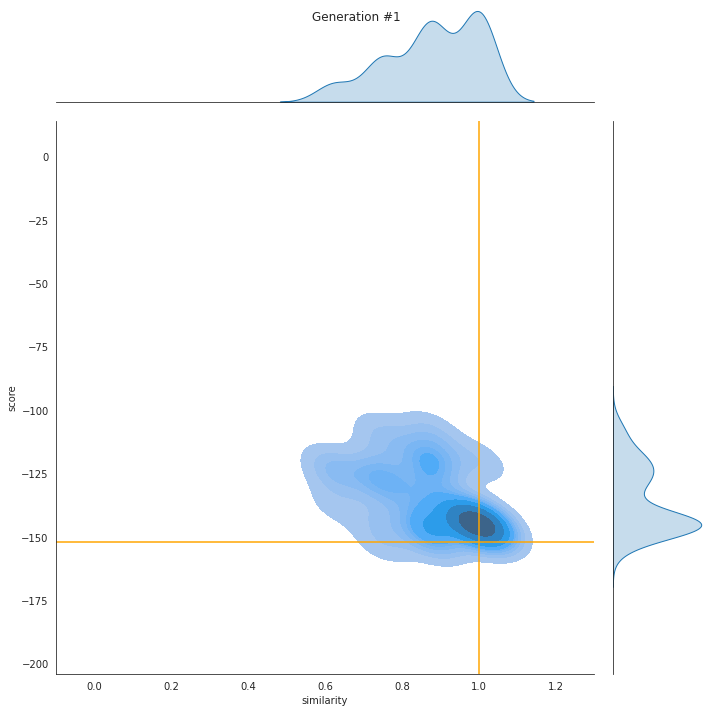

<Figure size 432x288 with 0 Axes>

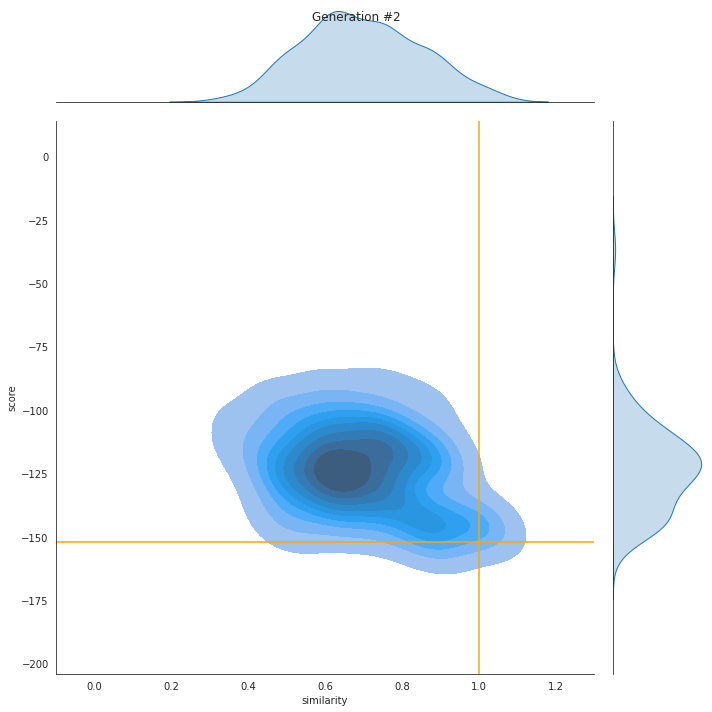

<Figure size 432x288 with 0 Axes>

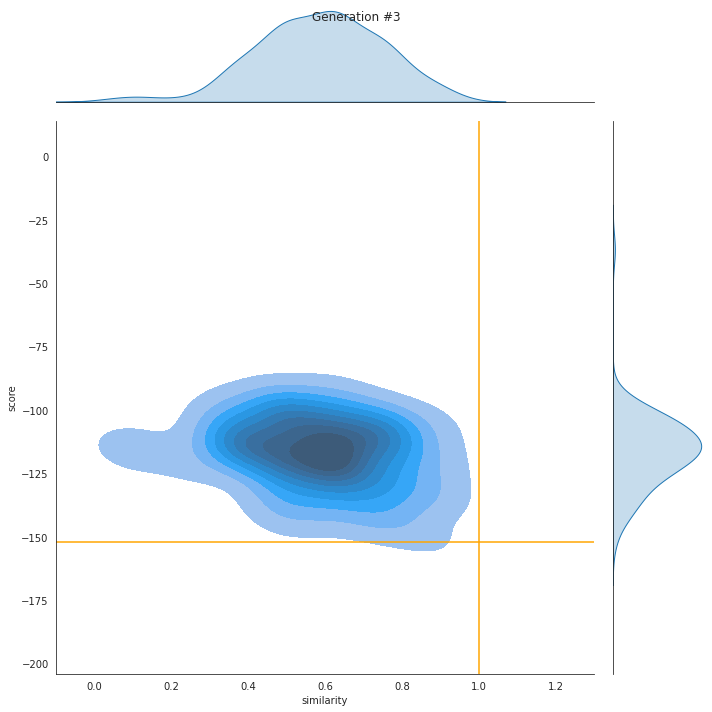

<Figure size 432x288 with 0 Axes>

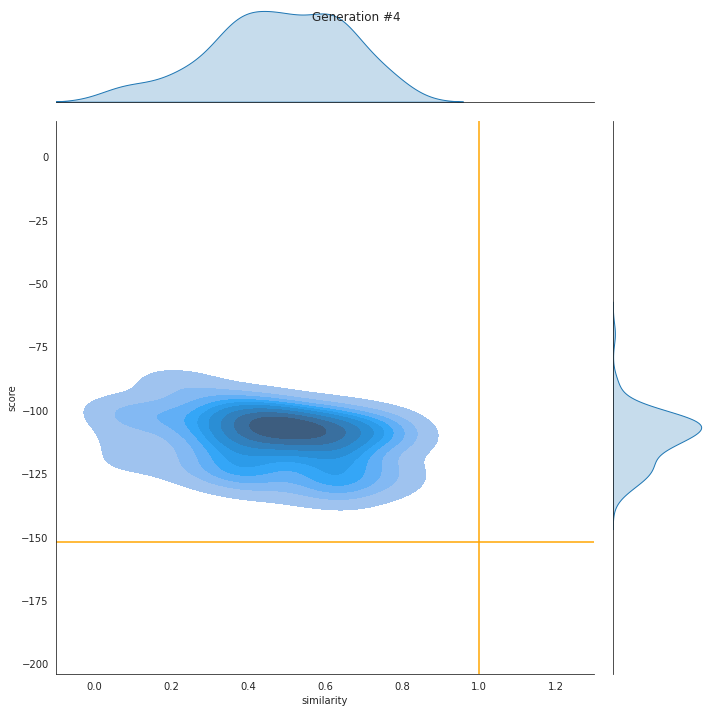

<Figure size 432x288 with 0 Axes>

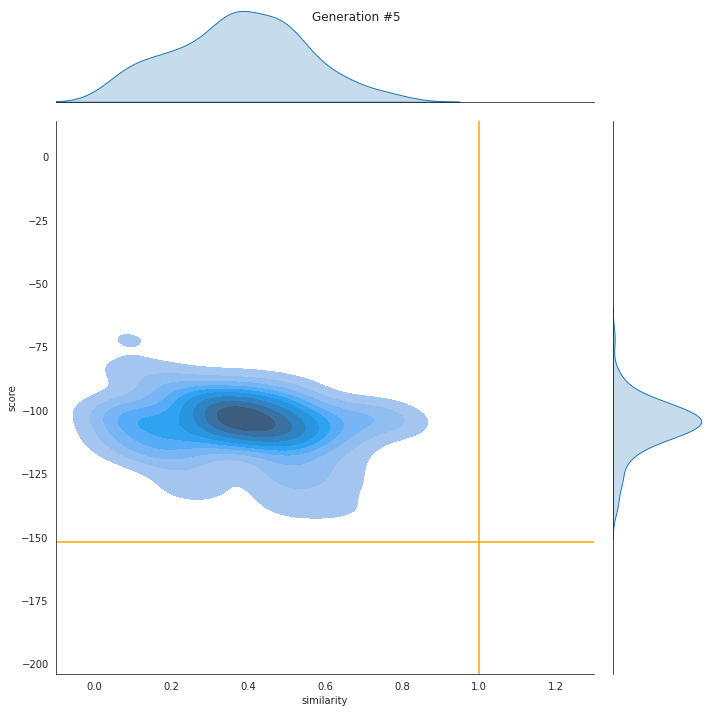

<Figure size 432x288 with 0 Axes>

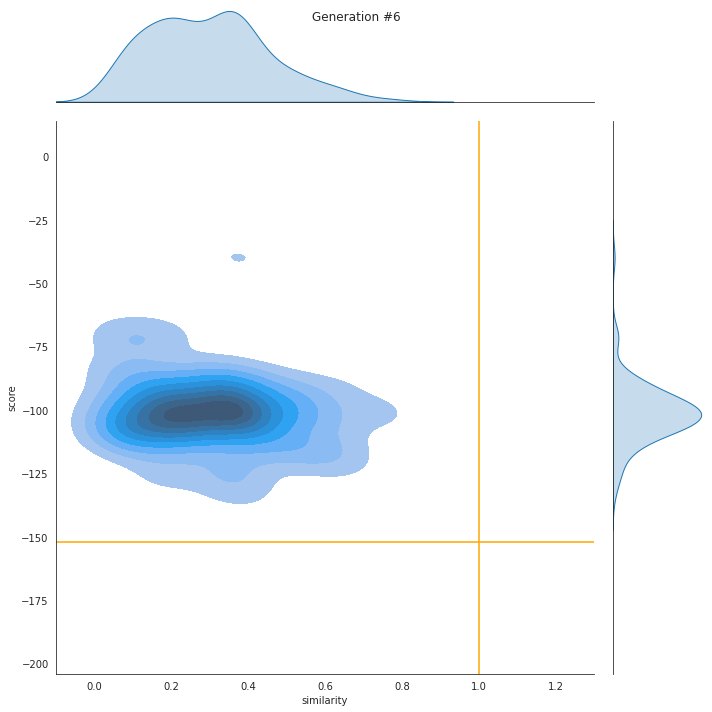

<Figure size 432x288 with 0 Axes>

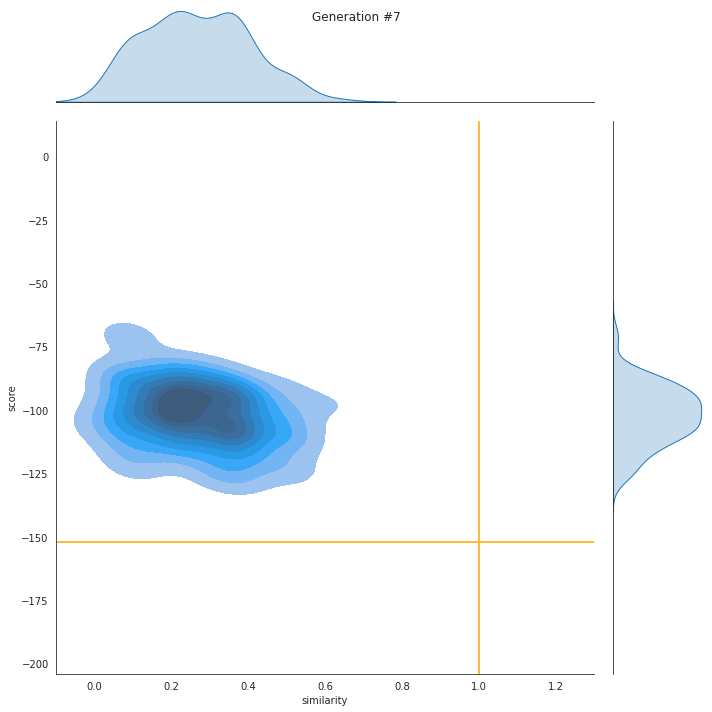

<Figure size 432x288 with 0 Axes>

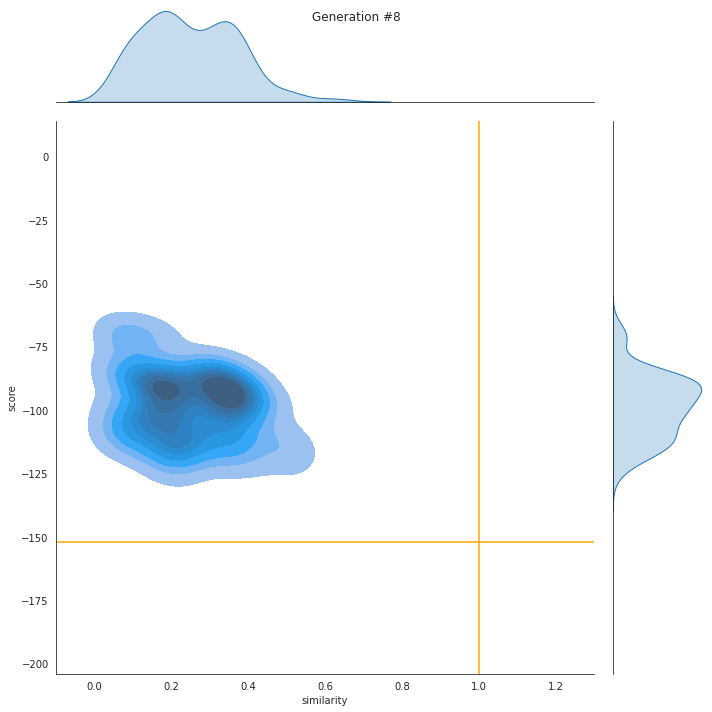

<Figure size 432x288 with 0 Axes>

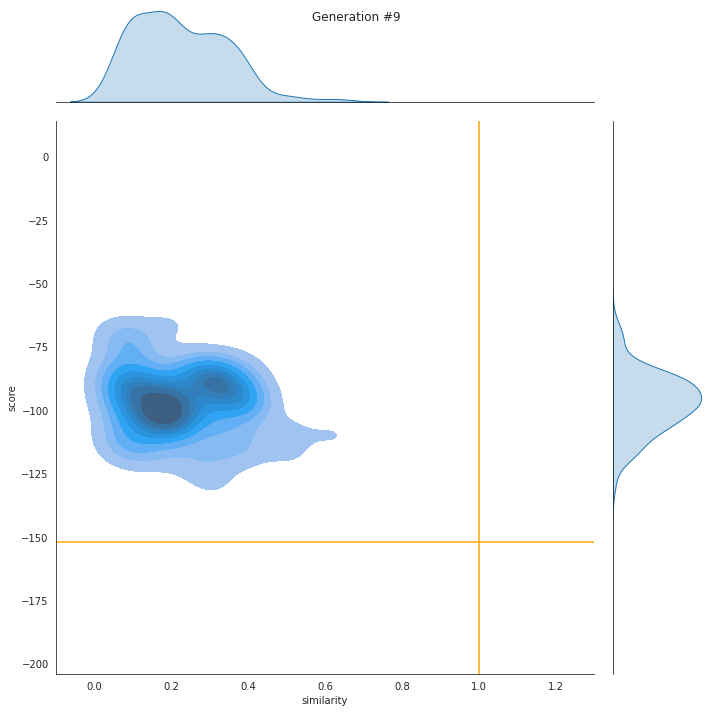

<Figure size 432x288 with 0 Axes>

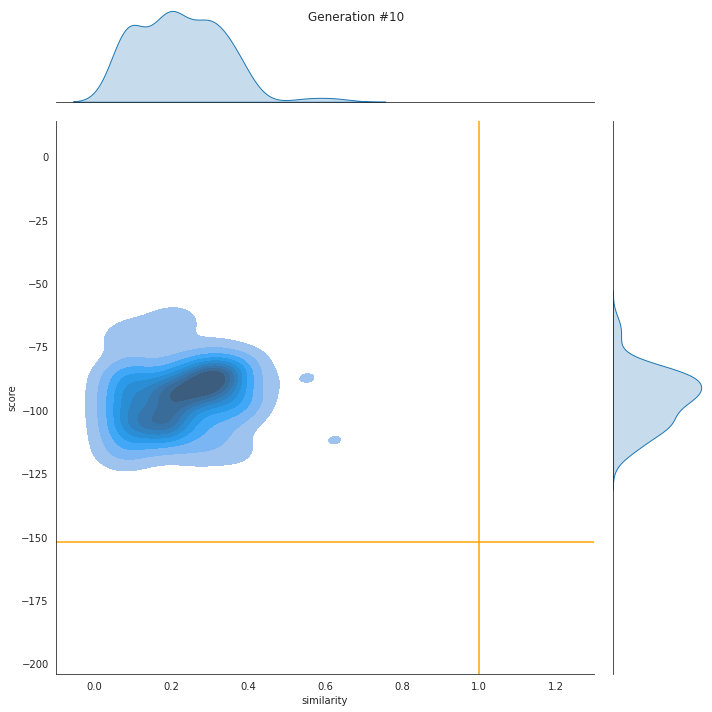

<Figure size 432x288 with 0 Axes>

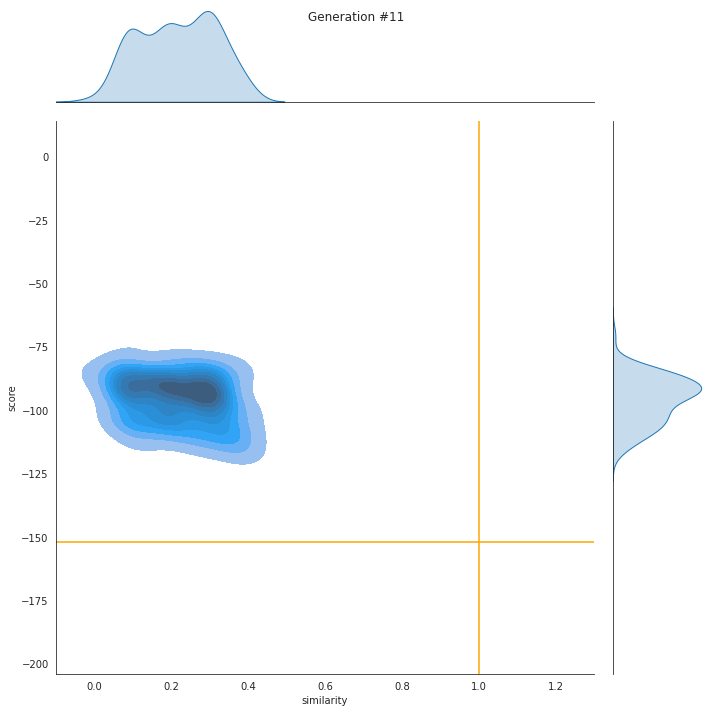

<Figure size 432x288 with 0 Axes>

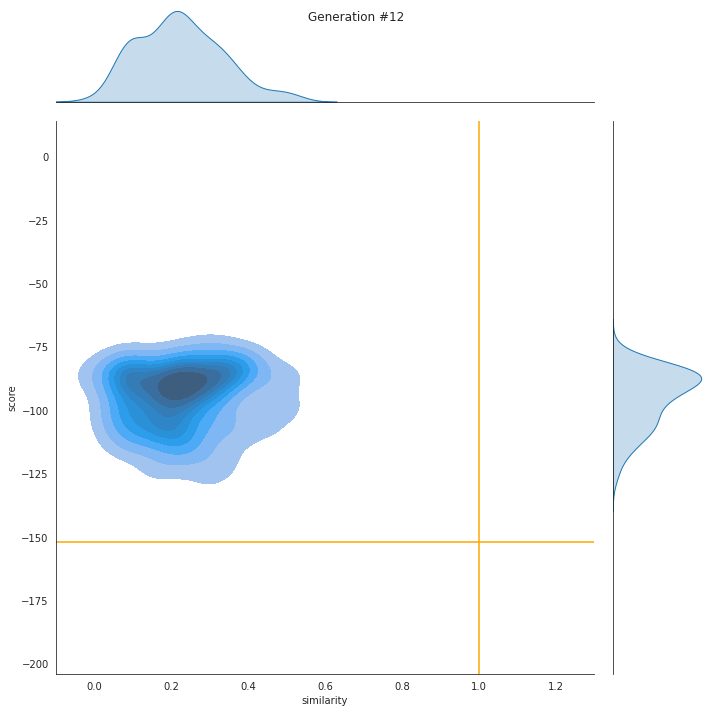

<Figure size 432x288 with 0 Axes>

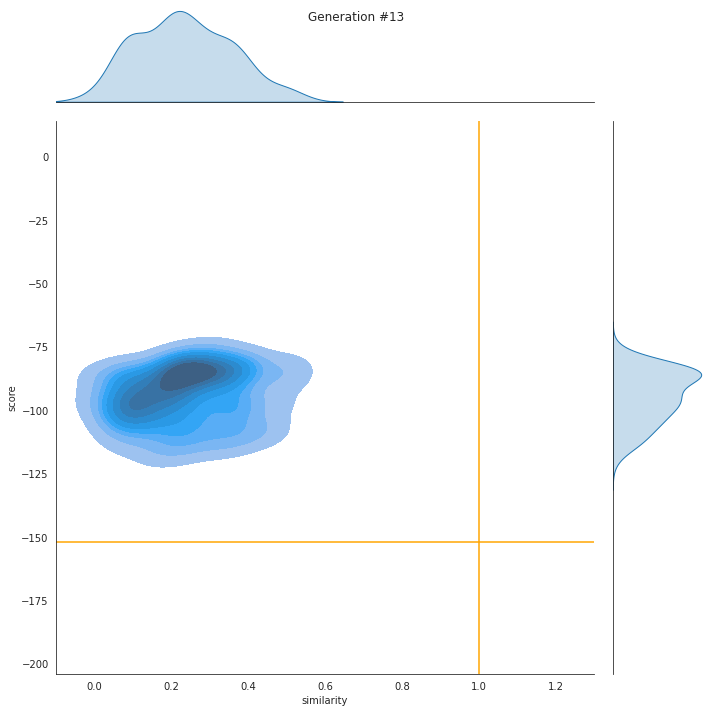

<Figure size 432x288 with 0 Axes>

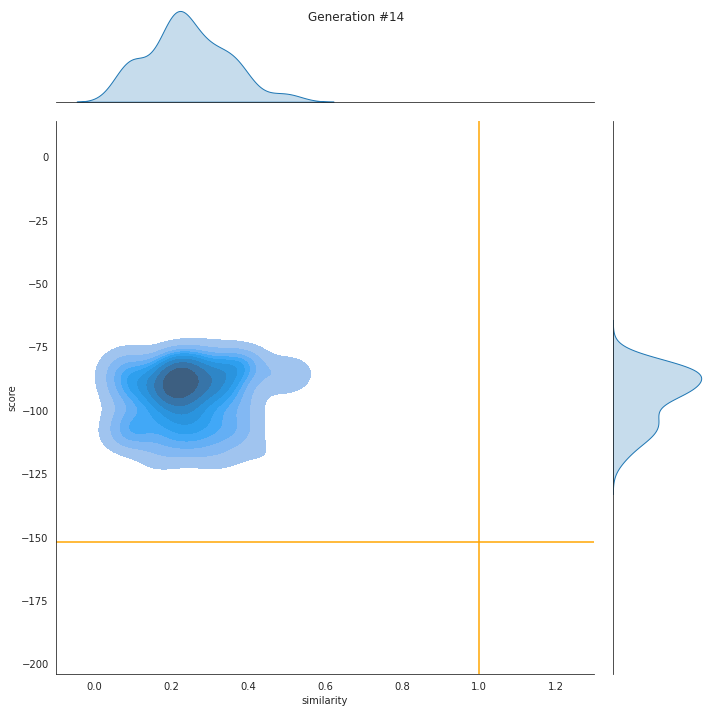

<Figure size 432x288 with 0 Axes>

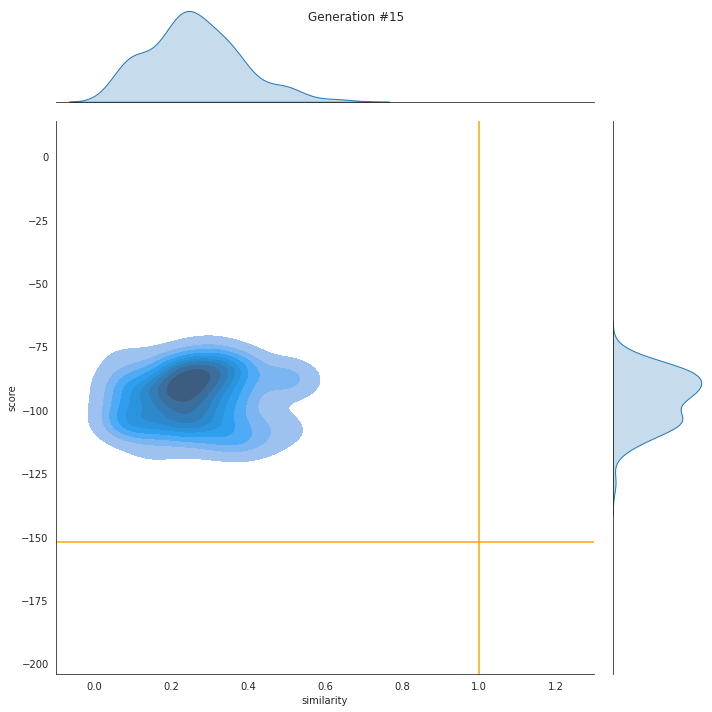

In [7]:
# Generate one KDE plot per generation
generation_l = list(set(df['generation'].to_list()))

score_l = df['score'].to_list()
min_y = int(min(score_l)) - 50
max_y = int(max(score_l)) + 50

sns.set_style("white")
for gen in generation_l:
    _df = df[df['generation'] == gen]
    plt.figure()
    plot = sns.jointplot(data=_df, x="similarity", y="score", kind='kde', fill=True, xlim =(-0.1, 1.3), ylim=(min_y, max_y), height=10)
    plot.fig.suptitle(f"Generation #{gen}")
    plot.ax_joint.axvline(x=1, color='orange')
    plot.ax_joint.axhline(y=REF_HADDOCKSCORE, color='orange')
    plot.savefig(f"{str(gen).zfill(4)}.png")


Convert the multiple plots in a gif with the following command;
```
convert -delay 20 -loop 0 *.png ab-design.gif
```